# EOPF: Sentinel‑2 UTM → HEALPix (Level‑1C)

**Audience:** Researchers, Data Scientists
**Last updated:** 2025-09-15

This notebook demonstrates a clear, reproducible workflow to convert Sentinel‑2 L1C data
from its native UTM projection to a global **HEALPix** grid, following the style of the
[EOPF Sentinel‑2 examples].

**You will learn to:**
- Access cloud‑native Sentinel‑2 Zarr data (via STAC/EOPF)
- Subset a region of interest (ROI)
- Attach latitude/longitude coordinates to UTM gridded data
- Reproject/aggregate onto a **HEALPix** equal‑area grid
- Inspect and save the result for downstream analysis

**Prerequisites:** Python, Xarray, familiarity with EO data, basic projections.

> Tip: Run the notebook top‑to‑bottom in a fresh environment for best results.

## Table of Contents

1. [Introduction](#introduction)
2. [Environment & Dependencies](#environment--dependencies)
3. [Data Access via STAC](#data-access-via-stac)
4. [Open the Sentinel‑2 Product](#open-the-sentinel2-product)
5. [Subset a Region of Interest](#subset-a-region-of-interest)
6. [Quicklook & Visualization](#quicklook--visualization)
7. [Add Latitude/Longitude Coordinates](#add-latitudelongitude-coordinates)
8. [Convert to HEALPix](#convert-to-healpix)
9. [Inspect the HEALPix Output](#inspect-the-healpix-output)
10. [Save & Export](#save--export)
11. [Appendix / References](#appendix--references)


## Introduction

Sentinel‑2 Level‑1C products are distributed in **UTM** tiles (projected meters). Many global
analyses benefit from a sphere‑aware, **equal‑area** grid. **HEALPix** (Hierarchical Equal Area
isoLatitude Pixelization) partitions the globe into equal‑area cells, making aggregations and
comparisons consistent across latitudes. This notebook restructures the original workflow with
clear chapters and explanations while preserving all original code and outputs.

This is a **Skelton** Notebook Converting EOPF Zarr format in UTM to HEALPix;
We use EOPF Sample service data here.
Since EOPF data is based on Datatree, we use that property. Thus this workflow can be applied to any UTM expressed EOPF ZARR format. (cf S2L1C and S2L2A)

## Environment & Dependencies

In [1]:
!pip install xarray-eopf  xdggs healpix-geo flox numbagg

### Imports and setup

- Loads libraries: matplotlib, numpy, xarray. Configures plotting options.

In [2]:
import numpy as np
import pyproj
import pystac_client
import xarray as xr
import hvplot.xarray 

## Data Access via STAC

We query the EOPF STAC catalog for a suitable Sentinel‑2 L1C item (e.g., low cloud cover, good sun elevation) and obtain the Zarr asset. This keeps the workflow cloud‑native and lazily loaded.

- To run this notebook with "sentinel-2-l1c", or "sentinel-2-l2a", simply specify it on the collections


In [3]:
# Access cloud-optimized Sentinel-2 data via the EOPF STAC catalog
catalog = pystac_client.Client.open("https://stac.core.eopf.eodc.eu")

# Define oceanographic study area and time window
LON, LAT = -4.5, 48  # Bay of Biscay - known for consistent wave patterns
date = "2025-06-17/2025-06-17"

# Search criteria optimized for wave analysis

collection = "sentinel-2-l1c"
#collection = "sentinel-2-l2a"

items = list(
    catalog.search(
        datetime=date,
        collections=[collection],
        intersects=dict(type="Point", coordinates=[LON, LAT]),
        query={
            "eo:cloud_cover": {
                "lt": 20
            },  # Cloud cover < 20% ensures clear ocean surface
            "view:sun_elevation": {
                "gt": 25
            },  # Filter for high sun elevation > 25° (→ sun zenith angle < 65°),
            # which places the sun near the zenith.
        },
    ).items()
)

for item in items:
    print(f"✅ {item.id}")

item = items[0]

✅ S2B_MSIL1C_20250617T112109_N0511_R037_T30UUU_20250617T131418


## Open the Sentinel‑2 Product

We open the product directly as an **Xarray DataTree** (lazy) to navigate measurements, conditions, and multi‑resolution groups (10m/20m/60m).


In [4]:
# Open the dataset lazily from object storage
dt = xr.open_datatree(
    item.assets["product"].href,
    **item.assets["product"].extra_fields["xarray:open_datatree_kwargs"],
)
dt

/srv/conda/envs/notebook/lib/python3.12/site-packages/xarray/backends/plugins.py:110: RuntimeWarning: Engine 'kerchunk' loading failed:
No module named 'zarr.core.array_spec'; 'zarr.core' is not a package
  external_backend_entrypoints = backends_dict_from_pkg(entrypoints_unique)


<xarray.DataTree>
Group: /
│   Attributes: (3)
├── Group: /conditions
│   ├── Group: /conditions/geometry
│   │       Dimensions:                        (angle: 2, band: 13, y: 23, x: 23,
│   │                                           detector: 7)
│   │       Coordinates:
│   │         * angle                          (angle) <U7 56B 'zenith' 'azimuth'
│   │         * band                           (band) <U3 156B 'b01' 'b02' ... 'b11' 'b12'
│   │         * detector                       (detector) int64 56B 3 4 5 6 7 8 9
│   │         * x                              (x) int64 184B 300000 305000 ... 410000
│   │         * y                              (y) int64 184B 5400000 5395000 ... 5290000
│   │       Data variables:
│   │           mean_sun_angles                (angle) float64 16B dask.array<chunksize=(2,), meta=np.ndarray>
│   │           mean_viewing_incidence_angles  (band, angle) float64 208B dask.array<chunksize=(13, 2), meta=np.ndarray>
│   │           sun_angles                     (angle, y, x) float64 8kB dask.array<chunksize=(2, 23, 23), meta=np.ndarray>
│   │           viewing_incidence_angles       (band, detector, angle, y, x) float64 770kB dask.array<chunksize=(7, 4, 2, 23, 23), meta=np.ndarray>
│   ├── Group: /conditions/mask
│   │   ├── Group: /conditions/mask/detector_footprint
│   │   │   ├── Group: /conditions/mask/detector_footprint/r10m
│   │   │   │       Dimensions:  (y: 10980, x: 10980)
│   │   │   │       Coordinates:
│   │   │   │         * x        (x) int64 88kB 300005 300015 300025 300035 ... 409775 409785 409795
│   │   │   │         * y        (y) int64 88kB 5399995 5399985 5399975 ... 5290225 5290215 5290205
│   │   │   │       Data variables:
│   │   │   │           b02      (y, x) uint8 121MB dask.array<chunksize=(10980, 10980), meta=np.ndarray>
│   │   │   │           b03      (y, x) uint8 121MB dask.array<chunksize=(10980, 10980), meta=np.ndarray>
│   │   │   │           b04      (y, x) uint8 121MB dask.array<chunksize=(10980, 10980), meta=np.ndarray>
│   │   │   │           b08      (y, x) uint8 121MB dask.array<chunksize=(10980, 10980), meta=np.ndarray>
│   │   │   ├── Group: /conditions/mask/detector_footprint/r20m
│   │   │   │       Dimensions:  (y: 5490, x: 5490)
│   │   │   │       Coordinates:
│   │   │   │         * x        (x) int64 44kB 300010 300030 300050 300070 ... 409750 409770 409790
│   │   │   │         * y        (y) int64 44kB 5399990 5399970 5399950 ... 5290250 5290230 5290210
│   │   │   │       Data variables:
│   │   │   │           b05      (y, x) uint8 30MB dask.array<chunksize=(5490, 5490), meta=np.ndarray>
│   │   │   │           b06      (y, x) uint8 30MB dask.array<chunksize=(5490, 5490), meta=np.ndarray>
│   │   │   │           b07      (y, x) uint8 30MB dask.array<chunksize=(5490, 5490), meta=np.ndarray>
│   │   │   │           b11      (y, x) uint8 30MB dask.array<chunksize=(5490, 5490), meta=np.ndarray>
│   │   │   │           b12      (y, x) uint8 30MB dask.array<chunksize=(5490, 5490), meta=np.ndarray>
│   │   │   │           b8a      (y, x) uint8 30MB dask.array<chunksize=(5490, 5490), meta=np.ndarray>
│   │   │   └── Group: /conditions/mask/detector_footprint/r60m
│   │   │           Dimensions:  (y: 1830, x: 1830)
│   │   │           Coordinates:
│   │   │             * x        (x) int64 15kB 300030 300090 300150 300210 ... 409650 409710 409770
│   │   │             * y        (y) int64 15kB 5399970 5399910 5399850 ... 5290350 5290290 5290230
│   │   │           Data variables:
│   │   │               b01      (y, x) uint8 3MB dask.array<chunksize=(1830, 1830), meta=np.ndarray>
│   │   │               b09      (y, x) uint8 3MB dask.array<chunksize=(1830, 1830), meta=np.ndarray>
│   │   │               b10      (y, x) uint8 3MB dask.array<chunksize=(1830, 1830), meta=np.ndarray>
│   │   └── Group: /conditions/mask/l1c_classification
│   │       └── Group: /conditions/mask/l1c_classification/r60m
│   │               Dimensions:  (y: 1830, x: 18

## Subset a Region of Interest

We extract a small ROI (e.g., a size×size window) to demonstrate transformation and HEALPix conversion on a compact example.

If you use here 'size'=3, the notebook runs on pangeo-eosc cluster less than 30 seconds. 

In [5]:
# chose small area in UTM
## TODO, we can update here to chose  'one detection' area.
size=23
size=12
size=3

x_min=0
x_max=x_min+(size -1)
y_max=0
y_min=y_max+(size -1)
print(x_min,x_max,y_min,y_max)

utm_x_min=dt["conditions"]["geometry"]["sun_angles"].x[x_min]
utm_x_max=dt["conditions"]["geometry"]["sun_angles"].x[x_max]
utm_y_min=dt["conditions"]["geometry"]["sun_angles"].y[y_min]
utm_y_max=dt["conditions"]["geometry"]["sun_angles"].y[y_max]
print(utm_x_min,utm_x_max,utm_y_min,utm_y_max)


small_dt = dt.sel(
    x=slice(
        utm_x_min,
        utm_x_max,
    ),
    y=slice(
        utm_y_max,
        utm_y_min,
    ),
)
small_dt #5299995, 5290205

0 2 2 0
<xarray.DataArray 'x' ()> Size: 8B
array(300000)
Coordinates:
    x        int64 8B 300000 <xarray.DataArray 'x' ()> Size: 8B
array(310000)
Coordinates:
    x        int64 8B 310000 <xarray.DataArray 'y' ()> Size: 8B
array(5390000)
Coordinates:
    y        int64 8B 5390000 <xarray.DataArray 'y' ()> Size: 8B
array(5400000)
Coordinates:
    y        int64 8B 5400000


<xarray.DataTree>
Group: /
│   Attributes: (3)
├── Group: /conditions
│   ├── Group: /conditions/geometry
│   │       Dimensions:                        (angle: 2, band: 13, y: 3, x: 3, detector: 7)
│   │       Coordinates:
│   │         * angle                          (angle) <U7 56B 'zenith' 'azimuth'
│   │         * band                           (band) <U3 156B 'b01' 'b02' ... 'b11' 'b12'
│   │         * detector                       (detector) int64 56B 3 4 5 6 7 8 9
│   │         * x                              (x) int64 24B 300000 305000 310000
│   │         * y                              (y) int64 24B 5400000 5395000 5390000
│   │       Data variables:
│   │           mean_sun_angles                (angle) float64 16B dask.array<chunksize=(2,), meta=np.ndarray>
│   │           mean_viewing_incidence_angles  (band, angle) float64 208B dask.array<chunksize=(13, 2), meta=np.ndarray>
│   │           sun_angles                     (angle, y, x) float64 144B dask.array<chunksize=(2, 3, 3), meta=np.ndarray>
│   │           viewing_incidence_angles       (band, detector, angle, y, x) float64 13kB dask.array<chunksize=(7, 4, 2, 3, 3), meta=np.ndarray>
│   ├── Group: /conditions/mask
│   │   ├── Group: /conditions/mask/detector_footprint
│   │   │   ├── Group: /conditions/mask/detector_footprint/r10m
│   │   │   │       Dimensions:  (y: 1000, x: 1000)
│   │   │   │       Coordinates:
│   │   │   │         * x        (x) int64 8kB 300005 300015 300025 300035 ... 309975 309985 309995
│   │   │   │         * y        (y) int64 8kB 5399995 5399985 5399975 ... 5390025 5390015 5390005
│   │   │   │       Data variables:
│   │   │   │           b02      (y, x) uint8 1MB dask.array<chunksize=(1000, 1000), meta=np.ndarray>
│   │   │   │           b03      (y, x) uint8 1MB dask.array<chunksize=(1000, 1000), meta=np.ndarray>
│   │   │   │           b04      (y, x) uint8 1MB dask.array<chunksize=(1000, 1000), meta=np.ndarray>
│   │   │   │           b08      (y, x) uint8 1MB dask.array<chunksize=(1000, 1000), meta=np.ndarray>
│   │   │   ├── Group: /conditions/mask/detector_footprint/r20m
│   │   │   │       Dimensions:  (y: 500, x: 500)
│   │   │   │       Coordinates:
│   │   │   │         * x        (x) int64 4kB 300010 300030 300050 300070 ... 309950 309970 309990
│   │   │   │         * y        (y) int64 4kB 5399990 5399970 5399950 ... 5390050 5390030 5390010
│   │   │   │       Data variables:
│   │   │   │           b05      (y, x) uint8 250kB dask.array<chunksize=(500, 500), meta=np.ndarray>
│   │   │   │           b06      (y, x) uint8 250kB dask.array<chunksize=(500, 500), meta=np.ndarray>
│   │   │   │           b07      (y, x) uint8 250kB dask.array<chunksize=(500, 500), meta=np.ndarray>
│   │   │   │           b11      (y, x) uint8 250kB dask.array<chunksize=(500, 500), meta=np.ndarray>
│   │   │   │           b12      (y, x) uint8 250kB dask.array<chunksize=(500, 500), meta=np.ndarray>
│   │   │   │           b8a      (y, x) uint8 250kB dask.array<chunksize=(500, 500), meta=np.ndarray>
│   │   │   └── Group: /conditions/mask/detector_footprint/r60m
│   │   │           Dimensions:  (y: 167, x: 167)
│   │   │           Coordinates:
│   │   │             * x        (x) int64 1kB 300030 300090 300150 300210 ... 309870 309930 309990
│   │   │             * y        (y) int64 1kB 5399970 5399910 5399850 ... 5390130 5390070 5390010
│   │   │           Data variables:
│   │   │               b01      (y, x) uint8 28kB dask.array<chunksize=(167, 167), meta=np.ndarray>
│   │   │               b09      (y, x) uint8 28kB dask.array<chunksize=(167, 167), meta=np.ndarray>
│   │   │               b10      (y, x) uint8 28kB dask.array<chunksize=(167, 167), meta=np.ndarray>
│   │   └── Group: /conditions/mask/l1c_classification
│   │       └── Group: /conditions/mask/l1c_classification/r60m
│   │               Dimensions:  (y: 167, x: 167)
│   │               Coordinates:
│   │                 * x        (x) int64 1kB 300030 300090 30015

## Quicklook & Visualization

We visualize one or more bands (e.g., B02) to confirm the ROI and interpret pixel values before reprojection.

In [6]:

#(small_dt['quality']['l1c_quicklook']['r10m']['tci'].hvplot.rgb(x='x',y='y',bands='band',  )+small_dt['measurements']['reflectance']['r10m']['b02'].hvplot(x='x',y='y', ))


## Add Latitude/Longitude Coordinates

Using **pyproj** we transform UTM (x/y in meters) to geographic coordinates (lon/lat in degrees) and attach them as auxiliary coordinates. This enables subsequent binning onto a spherical grid.

### Annotate UTM with latitude and Longitude

In [7]:
def _add_latlon(ds: xr.Dataset, transformer: pyproj.Transformer) -> xr.Dataset:
    """Attach latitude/longitude coords + CF metadata to a Dataset with (x,y)."""
    if not {"x", "y"}.issubset(ds.dims):
        return ds

    xx, yy = np.meshgrid(ds["x"].values, ds["y"].values, indexing="xy")
    lon, lat = transformer.transform(xx, yy)

    ds = ds.assign_coords(
        longitude=(("y", "x"), lon),
        latitude=(("y", "x"), lat),
    )
    ds["latitude"].attrs.update(
        {
            "standard_name": "latitude",
            "long_name": "Latitude",
            "units": "degrees_north",
            "axis": "Y",
        }
    )
    ds["longitude"].attrs.update(
        {
            "standard_name": "longitude",
            "long_name": "Longitude",
            "units": "degrees_east",
            "axis": "X",
        }
    )

    # Make sure vars with (y,x) advertise the aux coords
    for var in ds.data_vars:
        if {"y", "x"}.issubset(ds[var].dims):
            existing = ds[var].attrs.get("coordinates", "").split()
            ds[var].attrs["coordinates"] = " ".join(
                sorted(set(existing) | {"latitude", "longitude"})
            )
    return ds


def add_latlon(
    path: str, ds: xr.Dataset, transformer: pyproj.Transformer
) -> xr.Dataset:
    """Wrapper for safe application on a node dataset."""
    if ds is None:
        print(path, "no dataset")
        return ds
    if not {"x", "y"}.issubset(ds.dims):
        print(path, "not both x,y")
        return ds
    return _add_latlon(ds, transformer)


def add_latlon_to_dt(dt: xr.DataTree) -> xr.DataTree:
    """Return a new DataTree with latitude/longitude coords added everywhere possible."""
    crs_code = dt.attrs["other_metadata"]["horizontal_CRS_code"]
    src_crs = pyproj.CRS.from_string(crs_code)
    transformer = pyproj.Transformer.from_crs(
        src_crs, pyproj.CRS.from_epsg(4326), always_xy=True
    )
    return xr.DataTree.from_dict(
        {
            path: add_latlon(path, node.ds, transformer)
            for path, node in dt.subtree_with_keys
        }
    )

In [8]:
%%time
latlon_dt = add_latlon_to_dt(small_dt)

. not both x,y
conditions not both x,y
measurements not both x,y
quality not both x,y
conditions/mask not both x,y
conditions/meteorology not both x,y
measurements/reflectance not both x,y
quality/l1c_quicklook not both x,y
quality/mask not both x,y
conditions/mask/detector_footprint not both x,y
conditions/mask/l1c_classification not both x,y
conditions/meteorology/cams not both x,y
conditions/meteorology/ecmwf not both x,y
CPU times: user 788 ms, sys: 19.1 ms, total: 807 ms
Wall time: 807 ms


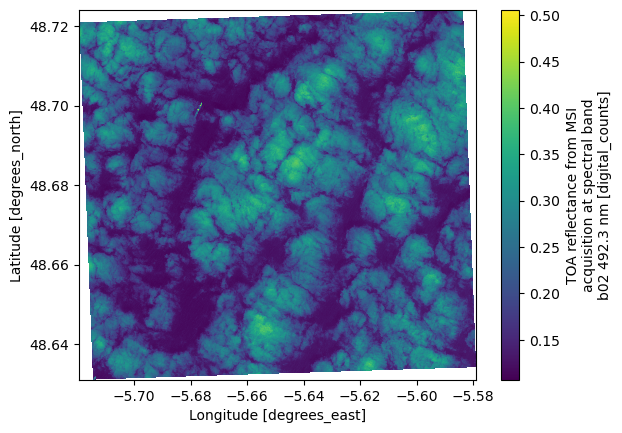

In [9]:
latlon_dt["measurements"]["reflectance"]["r10m"]["b02"].plot(
    x="longitude", y="latitude"
)

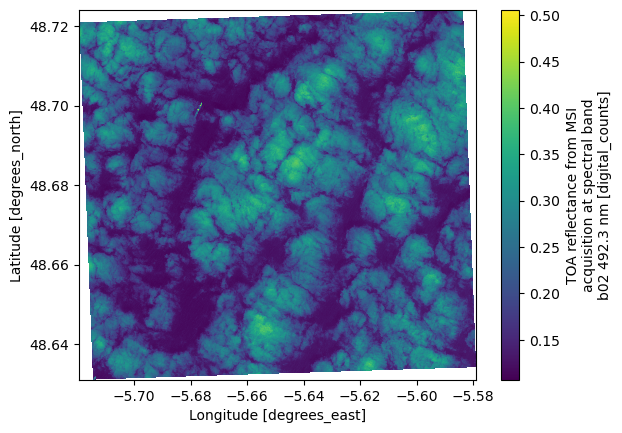

In [10]:
latlon_dt["measurements"]["reflectance"]["r10m"]["b02"].plot(
    x="longitude", y="latitude"
)

## Convert to HEALPix


In [11]:
# Conversion to HEALPix.
# Todo here: add 'data_tree' branch that indicate 'Healpix_level', i.e. instead of r10m,


from healpix_geo.nested import lonlat_to_healpix

# --- level selection (coarsest grid not finer than dx) ---
EARTH_RADIUS_M = 6_371_000.0  # radius used in healpix-geo levels table


def _healpix_edge_length_m(level: int, radius_m: float = EARTH_RADIUS_M) -> float:
    # edge = R * sqrt(pi/3) / 2**level  (matches healpix-geo "levels" page)
    return radius_m * np.sqrt(np.pi / 3.0) / (2**level)


def _infer_dx_from_x(ds: xr.Dataset) -> float:
    x = np.asarray(ds["x"].values)
    dx = float(np.nanmedian(np.abs(np.diff(x))))
    if not np.isfinite(dx) or dx <= 0:
        raise ValueError("Could not infer a positive spacing from ds['x'].")
    return dx


def choose_healpix_level_from_dx(
    ds: xr.Dataset, min_level: int = 0, max_level: int = 29
) -> int:
    dx = _infer_dx_from_x(ds)
    base = EARTH_RADIUS_M * np.sqrt(np.pi / 3.0)
    level = int(np.floor(np.log2(base / dx)))  # edge(level) >= dx
    return int(np.clip(level, min_level, max_level))


# --- single-dataset transform -> grouped by unique HEALPix cell_ids ---
def to_healpix_cells_grouped_mean(
    ds: xr.Dataset, level: int | None = None, ellipsoid: str = "WGS84"
) -> xr.Dataset:
    """
    Returns a dataset with dims (angle, cell_ids), where 'cell_ids' is a
    dimension/coordinate containing unique HEALPix ids (NESTED).
    Values are averaged over all source samples that mapped to the same cell.
    """
    if not {"y", "x"}.issubset(ds.dims):
        raise ValueError("Dataset must have 'y' and 'x' dimensions.")
    if not {"latitude", "longitude"}.issubset(ds.coords):
        raise ValueError(
            "Dataset must have 'latitude' and 'longitude' coords (degrees)."
        )

    if level is None:
        level = choose_healpix_level_from_dx(ds)

    # 1) hash each (lon,lat) to HEALPix nested cell id
    lon = ds["longitude"].values.ravel()
    lat = ds["latitude"].values.ravel()
    cell_ids = lonlat_to_healpix(lon, lat, level, ellipsoid=ellipsoid)

    # 2) stack (y,x) -> cells
    out = ds.stack(cells=("y", "x"))

    # 3) attach cell_ids coord on 'cells'
    out = out.assign_coords(cell_ids=("cells", cell_ids.astype("int64")))
    out["cell_ids"].attrs.update(
        {
            "grid_name": "healpix",
            "level": level,
            "indexing_scheme": "nested",
        }
    )
    cell_ids_attrs = dict(out["cell_ids"].attrs)  # keep for after groupby

    # 4) drop redundant coords/vars
    #    drop_these = [n for n in ("x", "y", "latitude", "longitude") if n in out.variables]
    #    out = out.drop_vars(drop_these)

    # 5) group by cell_ids and average -> new dim named 'cell_ids'
    # **note** This is a very simplified test conversion, later this should be updated spline other interpolated method.
    out = out.groupby("cell_ids").mean()

    # 6) restore attrs on the new dimension coordinate
    if "cell_ids" in out.coords:
        out["cell_ids"].attrs.update(cell_ids_attrs)

    # 7) keep order stable for variables like (angle, cell_ids)
    #   for v in out.data_vars:
    #       if ("angle" in out[v].dims) and ("cell_ids" in out[v].dims):
    #           out[v] = out[v].transpose("angle", "cell_ids", ...)

    return out


# --- per-node handler for the DataTree pass ---
def _add_healpix_to_dt_node(path: str, ds: xr.Dataset) -> xr.Dataset:
    if ds is None:
        print(path, "no dataset — keeping empty node")
        return xr.Dataset()

    has_xy = {"x", "y"}.issubset(ds.dims)
    has_ll = {"latitude", "longitude"}.issubset(ds.coords)

    if has_xy and not has_ll:
        # stop the whole operation as requested
        raise RuntimeError(
            f"{path}: has x/y but missing latitude/longitude — aborting."
        )

    if has_ll and has_xy:
        depth = choose_healpix_level_from_dx(ds)
        print(
            f"{path}: chosen level {depth} (edge≈{_healpix_edge_length_m(depth):.4f} m)"
        )
        return to_healpix_cells_grouped_mean(ds, level=depth, ellipsoid="WGS84")

    # no lat/lon -> do nothing
    print(path, "no latitude/longitude — skipping")
    return ds


# --- public function: apply over the whole DataTree ---
def add_healpix_to_dt(dt: xr.DataTree) -> xr.DataTree:
    """Transform nodes to HEALPix (grouped mean per cell) where possible; preserve others."""
    mapping = {
        path: _add_healpix_to_dt_node(path, node.ds)
        for path, node in dt.subtree_with_keys
        # Here re-name pass if it is
    }
    return xr.DataTree.from_dict(mapping, name=getattr(dt, "name", None))

In [ ]:
%%time
# Convert the whole tree
healpix_dt = add_healpix_to_dt(latlon_dt)

. no latitude/longitude — skipping
conditions no latitude/longitude — skipping
measurements no latitude/longitude — skipping
quality no latitude/longitude — skipping
conditions/geometry: chosen level 10 (edge≈6366.8110 m)
conditions/mask no latitude/longitude — skipping
conditions/meteorology no latitude/longitude — skipping
measurements/reflectance no latitude/longitude — skipping
quality/l1c_quicklook no latitude/longitude — skipping
quality/mask no latitude/longitude — skipping
conditions/mask/detector_footprint no latitude/longitude — skipping
conditions/mask/l1c_classification no latitude/longitude — skipping
conditions/meteorology/cams no latitude/longitude — skipping
conditions/meteorology/ecmwf no latitude/longitude — skipping
measurements/reflectance/r10m: chosen level 19 (edge≈12.4352 m)
measurements/reflectance/r20m: chosen level 18 (edge≈24.8704 m)
measurements/reflectance/r60m: chosen level 16 (edge≈99.4814 m)
quality/l1c_quicklook/r10m: chosen level 19 (edge≈12.4352 m)


## Inspect the HEALPix Output

We check dimensions and metadata (e.g., `cell_ids`, level, indexing scheme) and ensure variables were preserved.

In [ ]:
# Inspect a specific node you know had lon/lat + x/y
healpix_dt["measurements"]["reflectance"]["r10m"]

## Save & Export

We persist the HEALPix‑indexed data as **Zarr**

In [ ]:
%%time
# todo rechunk here (may be re-use rechunk function justus will propose for cliamate dt for optimal chunking of healpix?)
#
healpix_dt.to_zarr(collection + "HEALPix.zarr", mode="w")

In [ ]:
xr.open_datatree(collection + "HEALPix.zarr", engine='zarr')

### Note: goto next notbook made by benoit on updating metadata?

- The bouding box of this area, if it exist in stac metadata, should follow the new shape defined by healpix (zig zag polygon due to healpix pixels
- r10m or such now in healpix, thus it should be updated with 19 and metadata on parents indicating '19' is a reference_level


### Store the DT in right chunk for HEALPix



## Appendix / References

- EOPF Sample Notebooks (Sentinel‑2): examples of structure and style for cloud‑native EO workflows.
- HEALPix: Górski et al., 2005. *ApJ* 622, 759–771.
- PyProj/PROJ: Coordinate transforms between projected and geographic systems.
- Xarray DataTree: Hierarchical datasets for multi‑group EO products.
